# Data Challenge - Détection d'anomalies non supervisée
**Antonin Durieux**

## 1. Introduction

### 1.1 Données et principe du challenge

Le but de ce challenge était de détecter des anomalies au sein d'un ensemble de séries temporelles issues de mesures d'accéléromètres montés sur hélioptères. Le jeu de données était fourni par Airbus, chacune des séries s'étendait sur un temps d'une minute, et elles étaient échantillonnées à une fréquence de 1024 Hz. Ainsi chaque série comptait 61440 points de mesure.  
Notre échantillon de données était constitué de 1677 observations d'entrainement, et de 2511 observations de test. Aucun label n'était fourni, il s'agissait donc d'une tâche de détection non supervisée. Le but était d'affecter un score d'anomalie à chacune des observations du jeu de test.  
Le critère de performance était l'aire sous la courbe ROC (AUC).

### 1.2 Présentation de ma démarche

Pour répondre aux objectifs de ce challenge, la méthode qui m'a permis de maximiser le score obtenu a consisté à m'appuyer sur des features statistiques calculées sur chacune des séries temporelles dans un premier temps, puis sur l'exploitation de leurs périodogrammes afin d'en extraire de l'information fréquentielle. Les scores d'anomalie sur ces features ont ensuite été calculés grâce à l'algorithme one-class SVM, qui permet de détecter des anomalies ou nouveautés dans l'ensemble de test vis-à-vis de l'ensemble d'entrainement.  
L'un des intérêts de ce challenge était la diversité des solutions potentielles à explorer. J'exposerai brièvement dans un dernier temps l'autre méthode qui m'a paru la plus intéressante bien qu'elle ne m'ait pas permis d'obtenir les scores les plus élevés : la projection du périodogramme par kernel-PCA.

**Imports des packages et helper functions**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy import signal
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

sns.set()

In [ ]:
def plot_proj_3d(projected_data, score, comp1, comp2, comp3):
    """Fonction permettant d'afficher un scatterplot 3D grâce 
    à plotly avec un vecteur de colorisation des points"""

    df = pd.DataFrame(projected_data)
    df['score'] = score

    fig = px.scatter_3d(
        data_frame=df,
        x=comp1, 
        y=comp2, 
        z=comp3,
        opacity=0.5,
        width=800,
        height=800,
        color='score')
    
    fig.show()

## 2. Import des donnés
Les données ont été enregistrées auparavant au format npy pour en accélérer le chargement.

In [4]:
xtrain = np.empty((1677,61440))
xtest = np.empty((2511,61440))

xtrain = np.load(file='drive/My Drive/Data_Challenge_MDI341/Raw_Data/xtrain_raw_array.npy')
xtest = np.load(file='drive/My Drive/Data_Challenge_MDI341/Raw_Data/xtest_raw_array.npy')

print(xtrain.shape)
print(xtest.shape)

(1677, 61440)
(2511, 61440)


En visualisant les séries, il n'est pas forcément évident de savoir sur la base de quels critères une série pourra être considérée comme une anomalie ou non. En revanche, il apparait que certaines d'entre elles se comportent clairement différemment des autres et peuvent probablement être considérées comme des anomalies, voici quelques exemples :

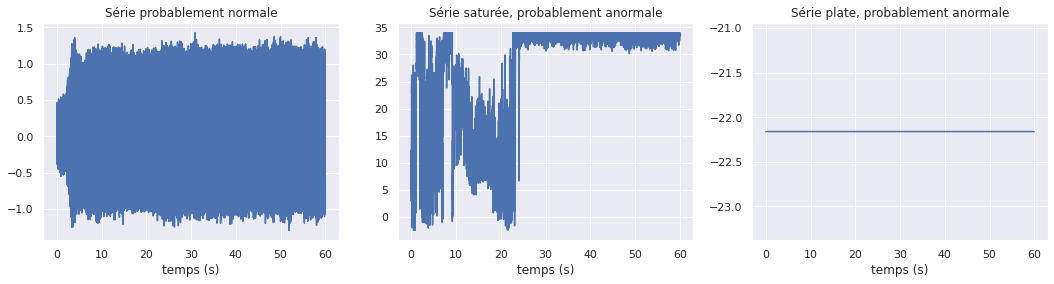

In [5]:
time_vect = np.array(range(61440)) / 1024

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(time_vect, xtrain[1])
plt.title("Série probablement normale")
plt.xlabel("temps (s)")

plt.subplot(1, 3, 2)
plt.plot(time_vect, xtest[1794])
plt.title("Série saturée, probablement anormale")
plt.xlabel("temps (s)")

plt.subplot(1, 3, 3)
plt.plot(time_vect, xtest[2368])
plt.title("Série plate, probablement anormale")
plt.xlabel("temps (s)")

plt.show()

## 3. Extraction des features statistiques sur les séries temporelles
Je me suis servi du package tsfresh (https://tsfresh.readthedocs.io/en/latest/#) afin d'extraire facilement des statistiques sur chacune des séries temporelles. Ce package permet d'extraire un grand nombre de features. J'ai choisi d'extraire toutes celles qui semblaient avoir un minimum de sens tout en étant calculable en un temps raisonnable, puis de ne conserver que les plus judicieuses par la suite.  
Le résultat est enregistré en DataFrames sérialisés au fromat Pickle pour ne pas relancer les calculs à chaque fois.

In [ ]:
# Chargement des DataFrames contenant les features statistiques sur les time-series
file = '/content/drive/My Drive/Data_Challenge_MDI341/Pickles/xtrain_stat_feats_df'
xtrain_feats_df = pd.read_pickle(file)

file = '/content/drive/My Drive/Data_Challenge_MDI341/Pickles/xtest_stat_feats_df'
xtest_feats_df = pd.read_pickle(file)

In [7]:
# Liste des features extraites
xtrain_feats_df.columns

Index(['ts__abs_energy', 'ts__absolute_sum_of_changes', 'ts__count_above_mean',
       'ts__count_below_mean', 'ts__has_duplicate_max',
       'ts__has_duplicate_min', 'ts__kurtosis', 'ts__maximum', 'ts__mean',
       'ts__mean_abs_change', 'ts__mean_second_derivative_central',
       'ts__median', 'ts__minimum', 'ts__skewness', 'ts__standard_deviation',
       'ts__sum_values', 'ts__variance'],
      dtype='object', name='variable')

A ce stade, une étape cruciale a été de réduire le nombre de features utilisés à un ensemble minimum, en procédant par essais-erreurs sur les soumissions. En effet parmi les 17 caractéristiques calculées, certaines sont redondantes, et la plupart n'apportent pas d'information ou dégradent même très fortement les résulats obtenus in fine : on peut supposer que certaines features font remonter beaucoup de faux positifs.  
De manière surprenante, les seules features qui semblent contribuer positivement au score sont en nombre très réduit et se sont les plus basiques : il s'agit de la moyenne et de l'écart-type, et la médiane ajoute également un peu d'information supplémentaire.

In [ ]:
# Sélection des features statistiques
feats = ['ts__mean',
         'ts__standard_deviation',
         'ts__median'
         ]

xtrain_feats_df = xtrain_feats_df[feats]
xtest_feats_df = xtest_feats_df[feats]

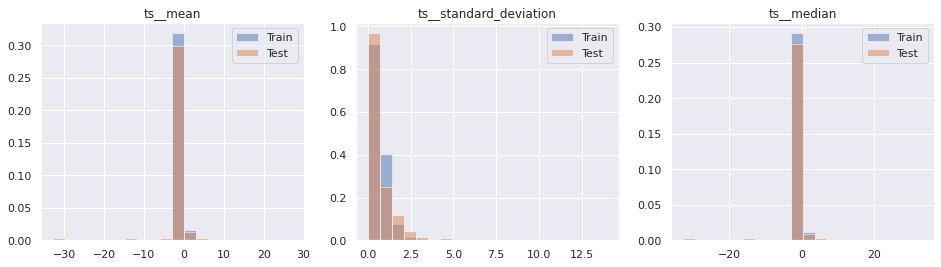

In [9]:
# Histogramme des features sélectionnés
plt.figure(figsize=(16,4))

for i, col in enumerate(xtrain_feats_df.columns): 
    plt.subplot(1, 3, i+1)
    bins = np.histogram(np.hstack((xtrain_feats_df[col],xtest_feats_df[col])), bins=20)[1]
    plt.hist(xtrain_feats_df[col], alpha=0.5, bins=bins, density=True, label='Train')
    plt.hist(xtest_feats_df[col], alpha=0.5, bins=bins, density=True, label='Test')
    plt.title(col)
    plt.legend()

On décèle sur les histogrammes de ces features que des outliers sont présents en faible quantité dans le jeu test. En appliquant un one-class SVM sur ces 3 features très basiques, le score obtenu était déjà de l'ordre de 0,836. 

## 4. Extraction d'informations sur les périodogrammes
L'étape suivante consiste à exploiter les informations fréquentielles contenues dans le périodogramme.

In [ ]:
# Calcul des périodogrammes
f, Pxx_den_train = signal.welch(xtrain, 
                          fs=1024, 
                          window='hanning', 
                          nperseg=256,
                          noverlap=None, 
                          nfft=None,
                          return_onesided=True, 
                          scaling='spectrum', 
                          axis=-1)

f, Pxx_den_test = signal.welch(xtest, 
                          fs=1024, 
                          window='hanning',
                          nperseg=256, 
                          noverlap=None, 
                          nfft=None, 
                          return_onesided=True, 
                          scaling='spectrum', 
                          axis=-1)

En comparant les périodogrammes issus des séries aux scores d'anomalie les plus hauts et les plus bas obtenus précédemment, on s'aperçoit qu'il semble y avoir des disparités parfois fortes entre les spectres des séries les plus normales et anormales :

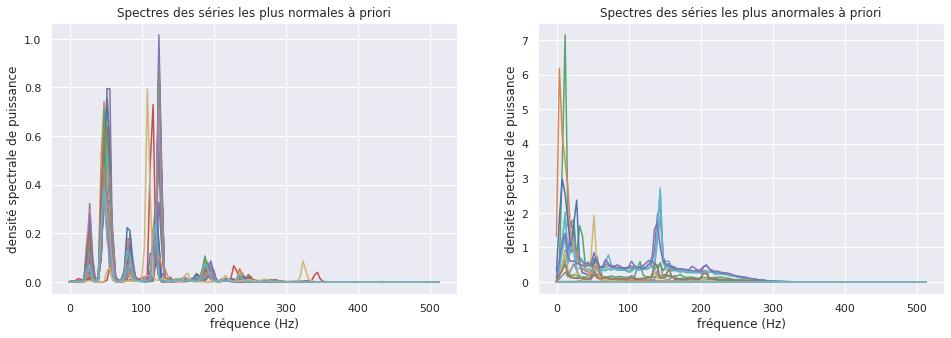

In [12]:
high_scores = [2362, 2363, 2364, 1983, 1980, 2368, 2369, 2356, 2370, 2378, 2379,
       1972, 2383, 1971, 1970, 2386, 2387, 1968, 2391, 2392, 2372, 2071,
       2355, 2353, 2062, 2060, 2311, 2051, 2313, 2048,  654, 2042, 2040,
       2320, 2321, 1997, 2325, 2328, 2033, 2032, 2337,  225, 2018, 2344,
       2007, 2348, 1999, 1998, 2037, 2002]

low_scores = [1578, 1248, 1721,  318, 1397, 1350,  185,  242,   69, 1566, 1252,
        609,  666, 1104, 1531, 1170,   96,  465, 1249, 1459,  671,  875,
       1699, 2441,  386,  712,  631, 1229,  491, 1627,  385, 1750, 1496,
       1483, 1489, 1884,  618,  432,  894,  238, 1402, 1672,  299,  547,
       1421, 1475,  809,  648, 2184, 1213]

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(f, Pxx_den_test[low_scores].T)
plt.title("Spectres des séries les plus normales à priori")
plt.xlabel("fréquence (Hz)")
plt.ylabel("densité spectrale de puissance")

plt.subplot(1, 2, 2)
plt.plot(f, Pxx_den_test[high_scores].T)
plt.title("Spectres des séries les plus anormales à priori")
plt.xlabel("fréquence (Hz)")
plt.ylabel("densité spectrale de puissance")

plt.show()

On constate sur ces spectres que la répartition de puissance en fonction des fréquences peut être très différente entre les 2 ensembles. Les pics les plus puissants n'apparaissent pas aux mêmes fréquences.  
Pour capturer ce type d'information plus précisémment et l'exploiter, j'ai testé plusieurs solutions mais celle qui a le mieux fonctionné à consisté à calculer :
- la fréquence à partir de laquelle 25% de la puissance totale du périodogramme d'une série a été atteinte ;
- la fréquence à partir de laquelle 50% de la puissance totale du périodogramme d'une série a été atteinte.

In [ ]:
# fonction de calcul de fréquence atteinte pour un taux de puissance cumulée
def f_cumsum(p_vect, f_vect, percentage):
    cumsum = np.cumsum(p_vect)
    break_point = cumsum[-1] * percentage
    arg = np.argmax(cumsum >= break_point) + 1
    f = f_vect[arg]
    p_sum = np.sum(p_vect[:arg])

    return f, p_sum

In [ ]:
# Calcul des fréquences correspondant à 25 et 50 % des puissances totales
train_f_p025 = []
train_f_p05 = []
test_f_p025 = []
test_f_p05 = []

for i in range(len(Pxx_den_train)):
    p_vect = Pxx_den_train[i]
    train_f_p025.append(f_cumsum(p_vect, f, 0.25)[0]) 
    train_f_p05.append(f_cumsum(p_vect, f, 0.5)[0]) 

for i in range(len(Pxx_den_test)):
    p_vect = Pxx_den_test[i]
    test_f_p025.append(f_cumsum(p_vect, f, 0.25)[0]) 
    test_f_p05.append(f_cumsum(p_vect, f, 0.5)[0]) 

xtrain_feats_df['f_p025'] = train_f_p025
xtrain_feats_df['f_p05'] = train_f_p05
xtest_feats_df['f_p025'] = test_f_p025
xtest_feats_df['f_p05'] = test_f_p05

On peut représenter ces 2 nouvelles features sous forme d'histogramme et de scatterplot pour visualiser leur répartition : 

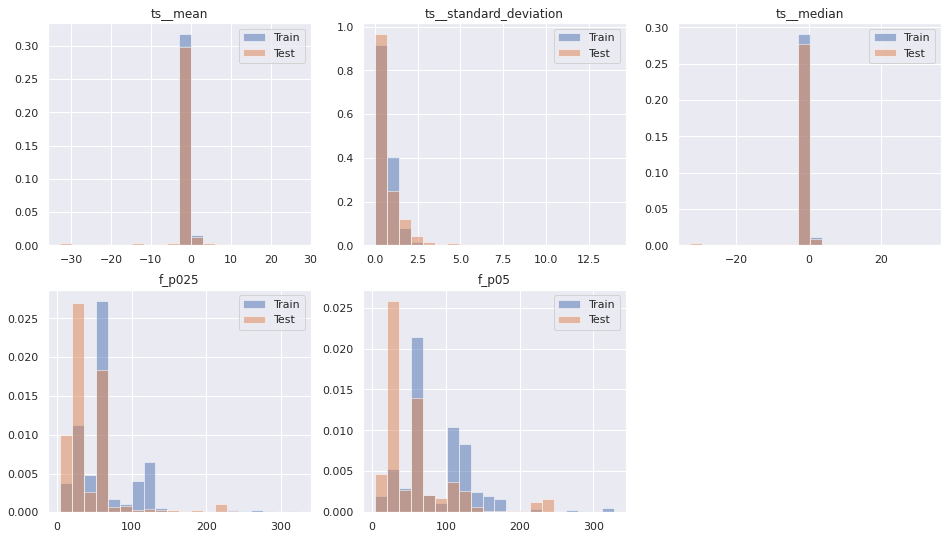

In [16]:
# Histogrammes des features obtenues
plt.figure(figsize=(16,9))

for i, col in enumerate(xtrain_feats_df.columns): 
    plt.subplot(2, 3, i+1)
    bins = np.histogram(np.hstack((xtrain_feats_df[col],xtest_feats_df[col])), bins=20)[1]
    plt.hist(xtrain_feats_df[col], alpha=0.5, bins=bins, density=True, label='Train')
    plt.hist(xtest_feats_df[col], alpha=0.5, bins=bins, density=True, label='Test')
    plt.title(col)
    plt.legend()

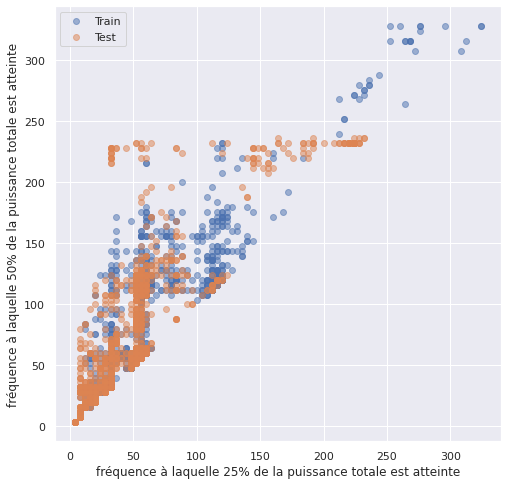

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(xtrain_feats_df['f_p025'], xtrain_feats_df['f_p05'], label='Train', alpha=0.5)
plt.scatter(xtest_feats_df['f_p025'], xtest_feats_df['f_p05'], label='Test', alpha=0.5)
plt.xlabel('fréquence à laquelle 25% de la puissance totale est atteinte')
plt.ylabel('fréquence à laquelle 50% de la puissance totale est atteinte')
plt.legend()
plt.show()

On voit sur ces représentations que certaines observations du jeu de test recouvrent des espaces inocuppés par le jeu d'entrainement.  
En ajoutant ces 2 features supplémentaires, le score final progresse fortement : on atteint 0.889 environ. 

## 5. Calcul des scores d'anomalies
Nous avons peu d'informations sur les données, aussi je suis parti de l'hypothèse que le jeu de données train étaient constitué d'exemples normaux. Ainsi, on peut entrainer un algorithme de détection d'anomalies ou de nouveautés en lui présentant les données du jeu train. Lorsqu'on lui présentera les données du jeu de test, l'algorithme affectera un score important aux exemples qui s'écartent de la distribution d'entrainement.  
Entre les algorithmes de l'isolation forest, du local outlier factor et du one-class SVM, ainsi qu'en testant des aggrégations de scores issus de ces différentes méthodes, c'est finalement le one-class SVM seul qui m'a permis d'obtenir les meilleurs scores pour mon ensemble de features.  

Je commence par ramener les vecteurs de features sur des plages de valeur comparables, au cas où les algorithmes de détection d'anomalies soient sensibles à des ordres de grandeur trop variés entre les différentes dimensions :

In [ ]:
feats = ['ts__mean', 'ts__standard_deviation', 'ts__median', 'f_p025', 'f_p05']

scaler = MinMaxScaler()

xtrain_feats_scaled = pd.DataFrame(scaler.fit_transform(xtrain_feats_df), columns=feats)
xtest_feats_scaled = pd.DataFrame(scaler.transform(xtest_feats_df), columns=feats)

Comme nous ne connaissons pas la qualité et la "pureté" du jeu d'entrainement, j'ai effectué l'apprentissage du one-class SVM en 2 temps :
- La première étape a consisté à effectuer un premier fit sur le jeu d'entrainement et à récupérer les scores ainsi obtenus sur ce même jeu d'entrainement ;
- Afin d'être sur que le SVM final n'était pas entrainé sur des exemples déviant trop de la norme et à "concentrer" leur distribution, j'ai retiré les observations du jeu train aux scores trop élevés.
Cette technique permet d'augmenter le score de manière marginale (moins de 1%).

In [ ]:
# Calcul des scores sur le jeu d'entrainement
svm = OneClassSVM(kernel='rbf',
                  gamma='scale',
                  tol=0.1, # 0.1
                  nu=0.05, # 0.05
                  shrinking=True,
                  cache_size=200, 
                  verbose=False, 
                  max_iter=-1)

svm.fit(xtrain_feats_scaled)
svm_train_scores = -svm.score_samples(xtrain_feats_scaled)

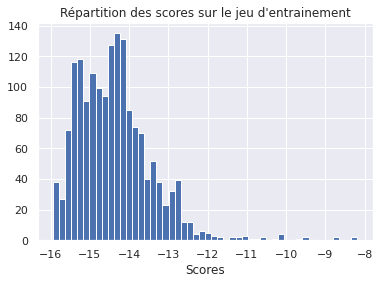

In [29]:
plt.hist(svm_train_scores, bins=50)
plt.title("Répartition des scores sur le jeu d'entrainement")
plt.xlabel("Scores")
plt.show()

In [ ]:
# Mise à l'écart des observations aux scores les plus extrêmes
best_train = np.where(svm_train_scores<-11.5)[0] 

Lors de l'entrainement final, on peut jouer un peu sur les paramètres du one-class SVM pour améliorer légèrement le résultat (moins de 1% d'amélioration lors de mes essais).

In [ ]:
# Ré-entrainement du OCSVM et calcul des scores sur le jeu de test
svm2 = OneClassSVM(kernel='rbf',
                  gamma='scale',
                  tol=0.07, 
                  nu=0.002, 
                  shrinking=True,
                  cache_size=200, 
                  verbose=False, 
                  max_iter=-1)

svm2.fit(xtrain_feats_scaled.iloc[best_train])
svm_test_scores = -svm2.score_samples(xtest_feats_scaled)

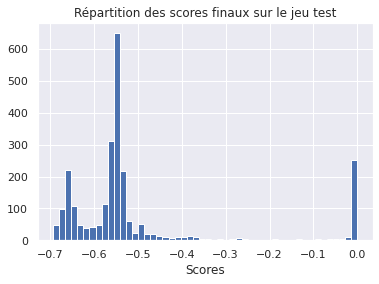

In [34]:
plt.hist(svm_test_scores, bins=50)
plt.title("Répartition des scores finaux sur le jeu test")
plt.xlabel("Scores")
plt.show()

On constate qu'un ensemble d'environ 250 observations s'est vu affecté un score maximal, les scores sont ensuite plus étalés jusqu'à une répartition des scores les plus bas sur 2 modes.

On peut visualiser les observations aux scores les plus élevés pour vérifier que l'algorithme semble avoir fonctionné correctement :

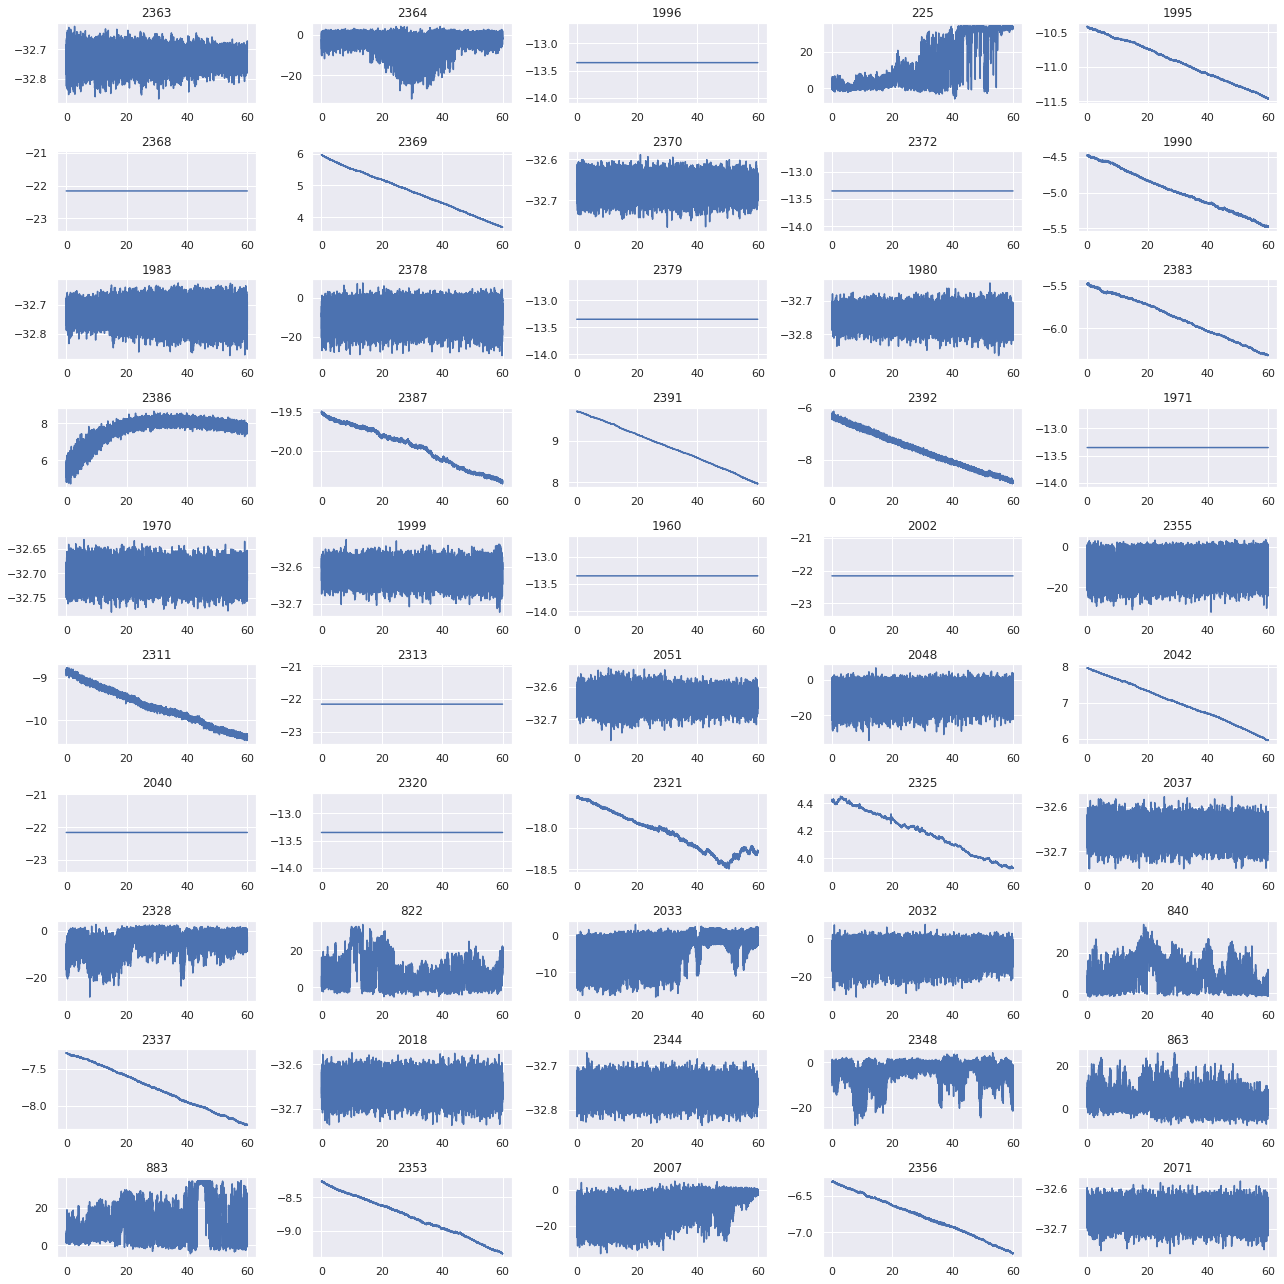

In [32]:
top_scores = np.argsort(svm_test_scores)[-50:]

plt.figure(figsize=(18, 18))

for i, index in enumerate(top_scores): 
    plt.subplot(10, 5, i+1)
    plt.plot(time_vect, xtest[index])
    plt.title(index)

plt.tight_layout()
plt.show()

On constate que l'algorithme a affecté un score élevé aux séries dont le signal est plat, saturé, instable, avec une enveloppe dissymétrique ou encore à celles dont la moyenne fait partie des plus négatives. Il semble que les scores les plus élevés correspondent bien à des séries anormales.

Avec cette méthode, mon meilleur score final a été atteint, aux alentours de 0.896.

## 6. Autres essais et méthodes alternatives

J'ai essayé plusieurs approches variées en complément de celle qui a le mieux marché, avec plus ou moins de succès. Certaines n'ont peut-être pas fonctionné car elles n'étaient pas adaptées au problème, ou parce que je ne suis pas parvenu à optimiser leur implémentation. Ces méthodes ont été :
- Réseaux de neurones : auto-encodeur et variational auto-encodeur, sur les séries temporelles ou sur les périodogrammes;
- PCA sur les séries temporelles ou sur les périodogrammes, avec algorithme de détection d'anomalie ou par erreur de reconstruction, et autres essais sur la sélection des composantes pouvant permettre de capter les erreurs plus efficacement;
- les mêmes essais que la PCA avec la kernel-PCA.  

Parmi tous ces essais, la méthode sur laquelle j'ai passé le plus de temps et qui me semblait la plus prometteuse était la détection d'erreur par kernel-PCA sur le périodogramme. Je vais l'exposer brièvement ici car les résultats m'ont tout de même semblés intéressants.

### 6.1 Approche par kernel-PCA sur le périodogramme

J'ai commencé par calculer des périodogrammes relativement denses en fréquence, puis à calculer la projection des jeux train et test sur un faible nombre de composantes par kernel-PCA avec noyau RBF. La paramétrisation de la kernel-PCA est délicate et il semble utile de visualiser les projections dans un espace 3D pour une meilleure intuition sur les résultats.

In [ ]:
# Calcul des périodogrammes
f, pxx_train = signal.periodogram(xtrain, fs=1024, scaling='spectrum', axis=-1)
f, pxx_test = signal.periodogram(xtest, fs=1024, scaling='spectrum', axis=-1)

In [ ]:
# Kernel-PCA
kpca = KernelPCA(n_components=10, 
                 kernel='rbf', 
                 gamma=0.01, 
                 eigen_solver='auto', 
                 tol=0,
                 max_iter=None, 
                 remove_zero_eig=False, 
                 random_state=None, 
                 copy_X=True,
                 n_jobs=-1)

xtrain_kpca = kpca.fit_transform(pxx_train)
xtest_kpca = kpca.fit_transform(pxx_test) 

On peut visualiser la projection du jeu test sur les 3 premières composantes par exemple. En utilisant une échelle de couleur correspondant aux scores d'anomalie finaux calculés avec la première méthode, on peut visualiser comment se répartissent les scores dans ce nouvel espace :

In [1]:
# visualisation 
#plot_proj_3d(xtest_kpca, svm_test_scores, 0, 1, 2) 

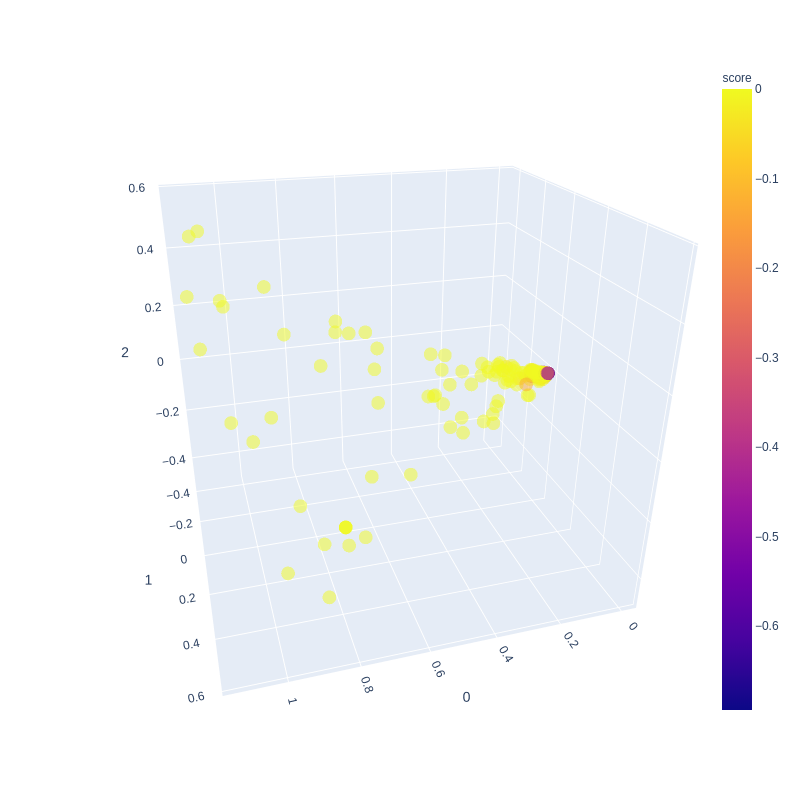

On constate que les scores les plus faibles sont très concentrés dans cet espace, alors que les points aux scores les plus élevés se détachent et s'éparpillent. Ce constat me semble intéressant car cela montre qu'entre les 2 techniques très différentes, on parvient tout de même à isoler des anomalies similaires. L'avantage de cette technique est qu'elle ne demande pas de feature engineering, en revanche elle demande de trouver un paramétrage adéquat pour la projection.  
L'algorithme de détection d'anomalie le plus adapté pour cette approche semble être le local outlier factor.

In [ ]:
# Calcul des scores avec le local outlier factor
lof = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof.fit(xtrain_kpca)
kpca_test_scores = -lof.score_samples(xtest_kpca)

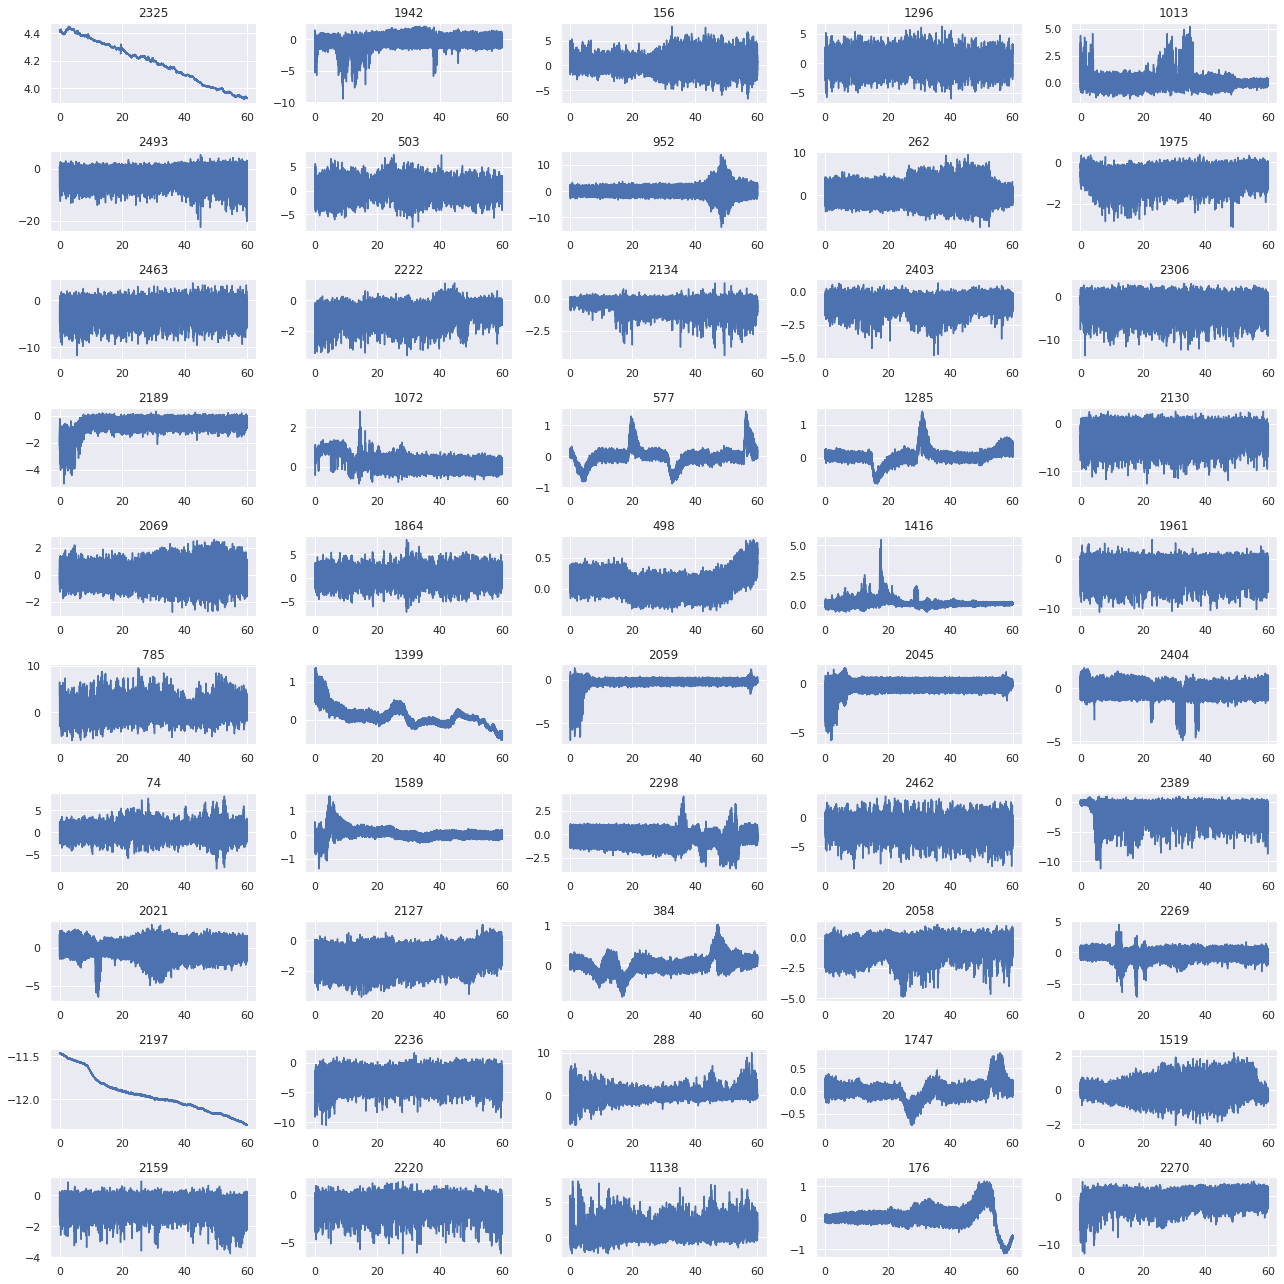

In [38]:
# Affichage des séries aux scores les plus élevés
top_scores_kpca = np.argsort(kpca_test_scores)[-50:]

plt.figure(figsize=(18, 18))

for i, index in enumerate(top_scores_kpca): 
    plt.subplot(10, 5, i+1)
    plt.plot(time_vect, xtest[index])
    plt.title(index)

plt.tight_layout()
plt.show()

On constate que cette méthode permet également de faire ressortir des traces anormales.  
Cependant les scores obtenus sont nettement moins bons qu'avec la première méthode : autour de 0,77 à un peu plus de 0,80 en aggrégeant avec d'autres techniques.

## 7. Conclusion
Cet exercice a été intéressant car la problématique ouvrait sur de nombreuses solutions potentielles à explorer. Cela a été l'occasion de se pencher sur les techniques et l'état de l'art en détection d'anomalies non supervisée. Comme dans la plupart des cas, les solutions les plus adaptées dépendent des données de travail et une phase d'exploration et d'essais de différentes méthodes permet de découvrir les approches plus ou moins efficaces.  
La première méthode que j'ai exposé m'a montré qu'il faut parfois savoir limiter au maximum le nombre de features à conserver pour ne pas introduire d'erreur, et qu'il peut être judicieux d'exploiter des informations de natures différentes si possible (domaines temporels et fréquentiels ici). Même si elle n'était pas si performante, j'ai trouvé intéressant que la méthode par kernel-PCA puisse permettre de recouper les anomalies avec une approche complètement différente. 